In [48]:
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, SimpleRNN, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [14]:
# PURPOSE OF THIS EXERCISE IS NOT TO PREDICT STOCK PRICE BUT GET AROUND SIMPLE FUNCTIONALITIES OF TF KERAS

In [3]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [13]:
print("                      Dataset Head          ")
print(df.head())
print("\n")
print("Shape of dataset is: ({},{})".format(df.shape[0], df.shape[1]))
print("\n")
print("                      Dataset Tail          ")
print(df.tail())

                      Dataset Head          
         date    open    high     low   close   volume  Name
0  2013-02-08  27.920  28.325  27.920  28.185  7146296  SBUX
1  2013-02-11  28.260  28.260  27.930  28.070  5457354  SBUX
2  2013-02-12  28.000  28.275  27.975  28.130  8665592  SBUX
3  2013-02-13  28.230  28.230  27.750  27.915  7022056  SBUX
4  2013-02-14  27.765  27.905  27.675  27.775  8899188  SBUX


Shape of dataset is: (1259,7)


                      Dataset Tail          
            date    open   high    low  close    volume  Name
1254  2018-02-01  56.280  56.42  55.89  56.00  14690146  SBUX
1255  2018-02-02  55.900  56.32  55.70  55.77  15358909  SBUX
1256  2018-02-05  55.530  56.26  54.57  54.69  16059955  SBUX
1257  2018-02-06  53.685  56.06  53.56  55.61  17415065  SBUX
1258  2018-02-07  55.080  55.43  54.44  54.46  13927022  SBUX


In [15]:
# We will do wrong the wrong this
series = df['close'].values.reshape(-1, 1)

In [34]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [40]:
### Build the dataset
T = 10
D = 1
X = []
Y = []

for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [44]:
X = np.array(X).reshape(-1, T, 1) # N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [50]:
# Try autoregressive RNN model
i = Input(shape=(T, D))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1)
)

In [51]:
# Train
r = model.fit(X[:-N//2], Y[:-N//2],
             epochs=80,
             validation_data=(X[-N//2:], Y[-N//2:])
             )

Epoch 1/80
20/20 [==============================] - 1s 35ms/step - loss: 0.1646 - val_loss: 0.1354
Epoch 2/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0165 - val_loss: 0.0543
Epoch 3/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0091 - val_loss: 0.0444
Epoch 4/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0492
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0712
Epoch 6/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0336
Epoch 7/80
20/20 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0300
Epoch 8/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0056 - val_loss: 0.0288
Epoch 9/80
20/20 [==============================] - 0s 9ms/step - loss: 0.0081 - val_loss: 0.0345
Epoch 10/80
20/20 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0540
Epoch 11/8

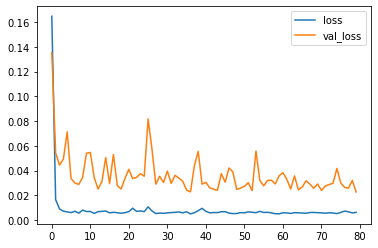

In [53]:
# plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [54]:
# one step forecast using the true targets
outputs = model.predict(X)
print(outputs.shape)

(1249, 1)


In [59]:
pred = outputs[:,0]

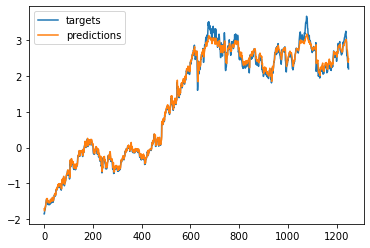

In [62]:
plt.plot(Y, label='targets')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

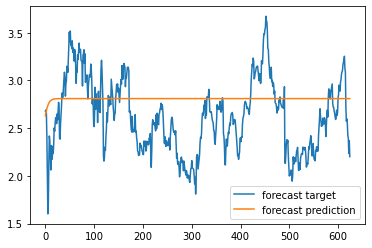

In [63]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [64]:
# calculate returns first by shifting the data
df["PrevClose"] = df['close'].shift(1)

In [66]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [67]:
df['Return'] = (df['close']-df['PrevClose']) / df['PrevClose']

In [68]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


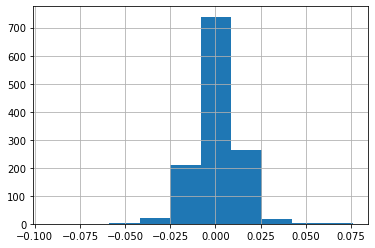

In [69]:
df['Return'].histt()

In [96]:
series = df['Return'][1:]
series = series.values.reshape(-1,1)
print("series shape: {}".format(series.shape))

series shape: (1258, 1)


In [98]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [99]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [101]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 1s 35ms/step - loss: 0.9962 - val_loss: 1.1620
Epoch 2/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9839 - val_loss: 1.1401
Epoch 3/80
20/20 [==============================] - 0s 15ms/step - loss: 0.9843 - val_loss: 1.1629
Epoch 4/80
20/20 [==============================] - 0s 13ms/step - loss: 0.9826 - val_loss: 1.1474
Epoch 5/80
20/20 [==============================] - 0s 17ms/step - loss: 0.9797 - val_loss: 1.1570
Epoch 6/80
20/20 [==============================] - 0s 13ms/step - loss: 0.9812 - val_loss: 1.1496
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9827 - val_loss: 1.1562
Epoch 8/80
20/20 [==============================] - 0s 16ms/step - loss: 0.9828 - val_loss: 1.1584
Epoch 9/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9790 - val_loss: 1.1725
Epoch 10/80
20/20 [==============================] - 0s 12ms/step - loss: 0.9693 - val_loss: 1.1625
Epoch 11/8

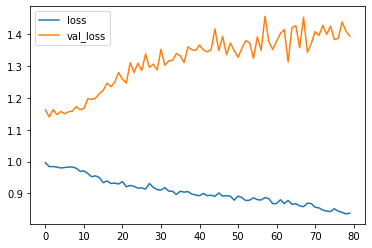

In [102]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


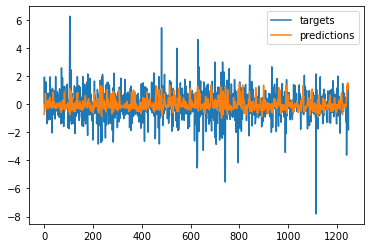

In [103]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

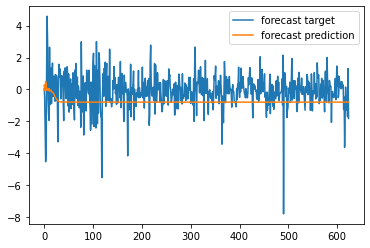

In [104]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [160]:
# Now using full data
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [161]:
T = 10
D = input_data.shape[1]
N = len(input_data)- T

In [162]:
input_data.shape

(1259, 5)

In [163]:
# normalise the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [164]:
# Setup X test and Y test
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t+T]
    Y_train[t] = (targets[t+T] > 0)

In [165]:
# Setup X and Y tests
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t+T]
    Y_test[u] = (targets[t+T] > 0)

In [166]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [167]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 30ms/step - loss: 0.6961 - accuracy: 0.5125 - val_loss: 0.6962 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.5185 - val_loss: 0.6973 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6927 - accuracy: 0.5232 - val_loss: 0.6965 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6922 - accuracy: 0.5209 - val_loss: 0.6913 - val_accuracy: 0.5293
Epoch 5/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6956 - accuracy: 0.5018 - val_loss: 0.6970 - val_accuracy: 0.4854
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6911 - accuracy: 0.5173 - val_loss: 0.6959 - val_accuracy: 0.4927
Epoch 7/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6902 - accuracy: 0.5161 - val_loss: 0.6913 - val_accuracy: 0.5366
Epoch 

27/27 [==============================] - 0s 11ms/step - loss: 0.6681 - accuracy: 0.5638 - val_loss: 0.6969 - val_accuracy: 0.5195
Epoch 59/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6671 - accuracy: 0.5769 - val_loss: 0.6960 - val_accuracy: 0.5171
Epoch 60/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6685 - accuracy: 0.5733 - val_loss: 0.7002 - val_accuracy: 0.5024
Epoch 61/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6635 - accuracy: 0.5673 - val_loss: 0.6978 - val_accuracy: 0.5122
Epoch 62/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6643 - accuracy: 0.5840 - val_loss: 0.6960 - val_accuracy: 0.5146
Epoch 63/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6624 - accuracy: 0.5816 - val_loss: 0.6964 - val_accuracy: 0.5317
Epoch 64/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6624 - accuracy: 0.5888 - val_loss: 0.6957 - val_accuracy: 0.5220
Epoch 65/300
2

27/27 [==============================] - 0s 16ms/step - loss: 0.5805 - accuracy: 0.6579 - val_loss: 0.7154 - val_accuracy: 0.4951
Epoch 116/300
27/27 [==============================] - 0s 15ms/step - loss: 0.5720 - accuracy: 0.6782 - val_loss: 0.7142 - val_accuracy: 0.4878
Epoch 117/300
27/27 [==============================] - 0s 17ms/step - loss: 0.5742 - accuracy: 0.6841 - val_loss: 0.7247 - val_accuracy: 0.5073
Epoch 118/300
27/27 [==============================] - 0s 17ms/step - loss: 0.5692 - accuracy: 0.6841 - val_loss: 0.7167 - val_accuracy: 0.4951
Epoch 119/300
27/27 [==============================] - 0s 16ms/step - loss: 0.5743 - accuracy: 0.6710 - val_loss: 0.7262 - val_accuracy: 0.5024
Epoch 120/300
27/27 [==============================] - 0s 16ms/step - loss: 0.5698 - accuracy: 0.6830 - val_loss: 0.7232 - val_accuracy: 0.4854
Epoch 121/300
27/27 [==============================] - 0s 16ms/step - loss: 0.5755 - accuracy: 0.6830 - val_loss: 0.7205 - val_accuracy: 0.5024
Epoch 

Epoch 172/300
27/27 [==============================] - 0s 10ms/step - loss: 0.4416 - accuracy: 0.7819 - val_loss: 0.7799 - val_accuracy: 0.5122
Epoch 173/300
27/27 [==============================] - 0s 9ms/step - loss: 0.4480 - accuracy: 0.7652 - val_loss: 0.7935 - val_accuracy: 0.5049
Epoch 174/300
27/27 [==============================] - 0s 9ms/step - loss: 0.4508 - accuracy: 0.7747 - val_loss: 0.7890 - val_accuracy: 0.5244
Epoch 175/300
27/27 [==============================] - 0s 11ms/step - loss: 0.4423 - accuracy: 0.7640 - val_loss: 0.7878 - val_accuracy: 0.5049
Epoch 176/300
27/27 [==============================] - 0s 9ms/step - loss: 0.4461 - accuracy: 0.7664 - val_loss: 0.7905 - val_accuracy: 0.5146
Epoch 177/300
27/27 [==============================] - 0s 9ms/step - loss: 0.4364 - accuracy: 0.7867 - val_loss: 0.7977 - val_accuracy: 0.5122
Epoch 178/300
27/27 [==============================] - 0s 10ms/step - loss: 0.4311 - accuracy: 0.7735 - val_loss: 0.7959 - val_accuracy: 0.5

27/27 [==============================] - 0s 11ms/step - loss: 0.3172 - accuracy: 0.8558 - val_loss: 0.9252 - val_accuracy: 0.5049
Epoch 230/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3191 - accuracy: 0.8498 - val_loss: 0.8975 - val_accuracy: 0.5024
Epoch 231/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3077 - accuracy: 0.8605 - val_loss: 0.9008 - val_accuracy: 0.5293
Epoch 232/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3103 - accuracy: 0.8653 - val_loss: 0.9212 - val_accuracy: 0.5195
Epoch 233/300
27/27 [==============================] - 0s 11ms/step - loss: 0.3104 - accuracy: 0.8546 - val_loss: 0.9025 - val_accuracy: 0.5341
Epoch 234/300
27/27 [==============================] - 0s 9ms/step - loss: 0.3121 - accuracy: 0.8617 - val_loss: 0.9169 - val_accuracy: 0.5098
Epoch 235/300
27/27 [==============================] - 0s 10ms/step - loss: 0.3004 - accuracy: 0.8641 - val_loss: 0.9355 - val_accuracy: 0.5146
Epoch 236/

27/27 [==============================] - 0s 9ms/step - loss: 0.2014 - accuracy: 0.9201 - val_loss: 1.1289 - val_accuracy: 0.5146
Epoch 287/300
27/27 [==============================] - 0s 9ms/step - loss: 0.1980 - accuracy: 0.9178 - val_loss: 1.1305 - val_accuracy: 0.5098
Epoch 288/300
27/27 [==============================] - 0s 9ms/step - loss: 0.1949 - accuracy: 0.9249 - val_loss: 1.1193 - val_accuracy: 0.5146
Epoch 289/300
27/27 [==============================] - 0s 9ms/step - loss: 0.1885 - accuracy: 0.9213 - val_loss: 1.1347 - val_accuracy: 0.4854
Epoch 290/300
27/27 [==============================] - 0s 9ms/step - loss: 0.1943 - accuracy: 0.9154 - val_loss: 1.1545 - val_accuracy: 0.5073
Epoch 291/300
27/27 [==============================] - 0s 10ms/step - loss: 0.1845 - accuracy: 0.9309 - val_loss: 1.1743 - val_accuracy: 0.5220
Epoch 292/300
27/27 [==============================] - 0s 9ms/step - loss: 0.1982 - accuracy: 0.9225 - val_loss: 1.1511 - val_accuracy: 0.5122
Epoch 293/30

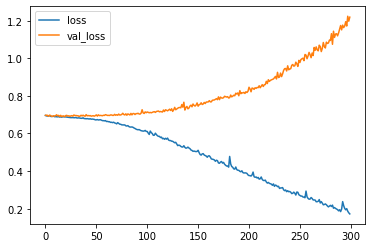

In [168]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

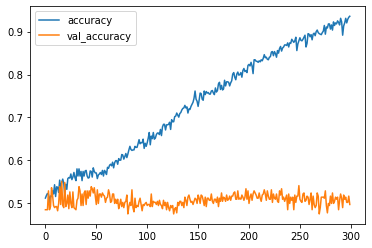

In [169]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()